## <font color="#00bfff">1.Cookie Cats and Project Goal</font>
<p>Cookie Cats</a> is a hugely popular mobile puzzle game developed by Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. 
<p>As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.</p>
<p>But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data.</p>


In [37]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

In [38]:
# Reading in the data
df = pd.read_csv(r'C:\Users\USER1\Desktop\cookie_cats.csv')
df.shape

(90189, 5)

In [39]:
# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [40]:
#showing the last few rows
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


## <font color="#00bfff">2. Dataset and Variables</font>
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>

<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>.

## <font color="#00bfff">3. Descriptive Statistics</font>

Let's deep dive into dataset and try to observe the differences between A/B group in terms of given variables. 

First, look at how many players we have.

In [41]:
# Count and display the number of unique players
print("Number of players: \n", df.userid.nunique(), '\n',
        "Number of records: \n", len(df.userid),'\n')

Number of players: 
 90189 
 Number of records: 
 90189 



In [42]:
plot_df = df.groupby('sum_gamerounds').count().reset_index()
plot_df.head()

,sum_gamerounds,userid,version,retention_1,retention_7
0,0,3994,3994,3994,3994
1,1,5538,5538,5538,5538
2,2,4606,4606,4606,4606
3,3,3958,3958,3958,3958
4,4,3629,3629,3629,3629


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [45]:
df.describe(include = 'object').T

,count,unique,top,freq
version,90189,2,gate_40,45489


In [46]:
# Function the plot the percentage of missing values
def na_counter(df):
    print("NaN Values per column:")
    print("")
    for i in df.columns:
        percentage = 100 - ((len(df[i]) - df[i].isna().sum())/len(df[i]))*100

        # Only return columns with more than 5% of NA values
        if percentage > 5:
            print(i+" has "+ str(round(percentage)) +"% of Null Values")
        else:
            continue

# Execute function
na_counter(df)

NaN Values per column:



In [47]:
# Counting the number of players in each AB group.
players_g30 = df[df['version'] == 'gate_30']
players_g40 = df[df['version'] == 'gate_40']

print('Number of players tested at Gate 30:', str(players_g30.shape[0]), '\n',
     'Number of players tested at Gate 40:', str(players_g40.shape[0]))

Number of players tested at Gate 30: 44700 
 Number of players tested at Gate 40: 45489


It looks like there is roughly the same number of players in each group, nice! 

The focus of this analysis will be on how the gate placement affects player retention, but just for fun: Let's plot the distribution of the number of game rounds players played during their first week playing the game.

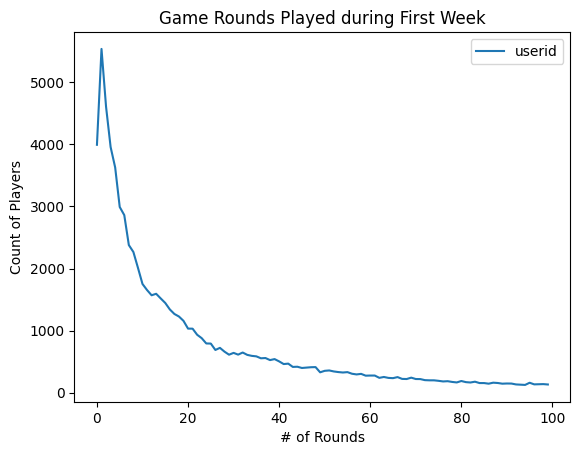

In [48]:
# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot('sum_gamerounds', 'userid')
ax.set_xlabel("# of Rounds")
ax.set_ylabel("Count of Players")
ax.set_title("Game Rounds Played during First Week");

In the plot above we can see that some players install the game but then never play it (0 game rounds). Let's find there are how many of them.

In [49]:
# Distribution Boxplot with outliers
box1 = px.box(df, x="sum_gamerounds",
            title = "Game Rounds Overall Distribution by player", labels = {"sum_gamerounds":"Game Rounds registered"})
box1.show()

In [50]:
print("Players inactive since installation: ", df[df["sum_gamerounds"] == 0].shape[0])

Players inactive since installation:  3994


3994 players never played the game, just installed it. Is it too much? 

A common metric in the video gaming industry for how fun and engaging a game is retention: The percentage of players that come back and play the game 1-day and 7-days after they have installed it. The higher retention is, the easier it is to retain players and build a large player base.

As a first step, let's look at what 1-day and 7-days retentions are overall.

In [51]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


So, a little less than half of the players come back one day after installing the game. 18 percent of the players come back 7 day after installing the game. 

Now that we have a benchmark, let's look at how retention rates differs between the two A/B groups.

In [52]:
# CONTROL GROUP
prop_gate30 = len(players_g30[players_g30['retention_1'] == True])/len(players_g30['retention_1']) * 100

# TREATMENT GROUP
prop_gate40 = len(players_g40[players_g40['retention_1'] == True])/len(players_g40['retention_1']) * 100

print('Group 30 at 1 day retention: ',str(round(prop_gate30,2)),"%","\n",
     'Group 40 at 1 day retention: ',str(round(prop_gate40,2)),"%")

Group 30 at 1 day retention:  44.82 % 
 Group 40 at 1 day retention:  44.23 %


In [53]:
# CONTROL GROUP
prop_gate30 = len(players_g30[players_g30['retention_7'] == True])/len(players_g30['retention_7']) * 100

# TREATMENT GROUP
prop_gate40 = len(players_g40[players_g40['retention_7'] == True])/len(players_g40['retention_7']) * 100

print('Group 30 at 7 day retention: ',str(round(prop_gate30,2)),"%","\n",
     'Group 40 at 7 day retention: ',str(round(prop_gate40,2)),"%")

Group 30 at 7 day retention:  19.02 % 
 Group 40 at 7 day retention:  18.2 %


* There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%). 

* Again,a decrease in 7-day retention when the gate was moved to level 40 (18.2%) compared to the control group when it was at level 30 (19.8%). 

* It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use **bootstrapping.**

## <font color="#00bfff"> 4. A/B Testing: Bootstrapping </font>

**Definiton of Method**
We'll use **bootstrapping** for A/B testing. The basic idea of bootstrapping is that inference about a population from sample data (sample → population) can be modelled by resampling the sample data and performing inference about a sample from resampled data (resampled → sample). As the population is unknown, the true error in a sample statistic against its population value is unknown. In bootstrap-resamples, the 'population' is in fact the sample, and this is known; hence the quality of inference of the 'true' sample from resampled data (resampled → sample) is measurable. [This information retrieved from Wikipedia]

**Testing Steps:**
1. Creating 500 samples of dataset **(bootstraping)**
2. Calculating 1-day & 7-days retentions for A/B groups
3. Plotting the bootstrap distributions
4. Calculating retention rate difference between the two A/B groups
5. Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30
6. Evaluating results and making recommendation

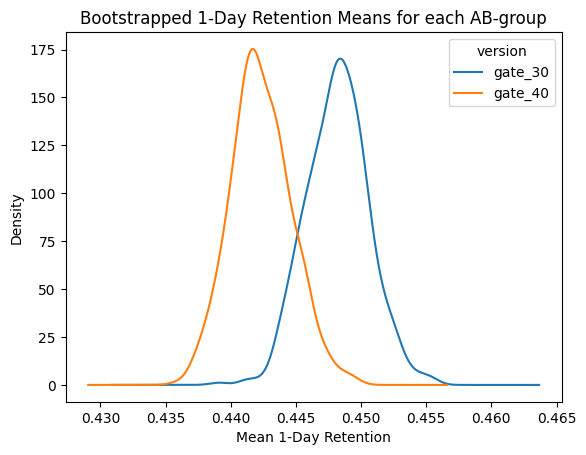

In [54]:
# Creating a list with bootstrapped means for each AB-group
boot_1d = []
iterations=500
for i in range(iterations):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_1d.plot.kde()
ax.set_title('Bootstrapped 1-Day Retention Means for each AB-group')
ax.set_xlabel('Mean 1-Day Retention');

In [55]:
# checking first few rows of boot_1d 
boot_1d.head()

version,gate_30,gate_40
retention_1,0.449365,0.440579
retention_1,0.446006,0.440711
retention_1,0.447420,0.443169
retention_1,0.449948,0.440688
retention_1,0.448982,0.442339


In [56]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

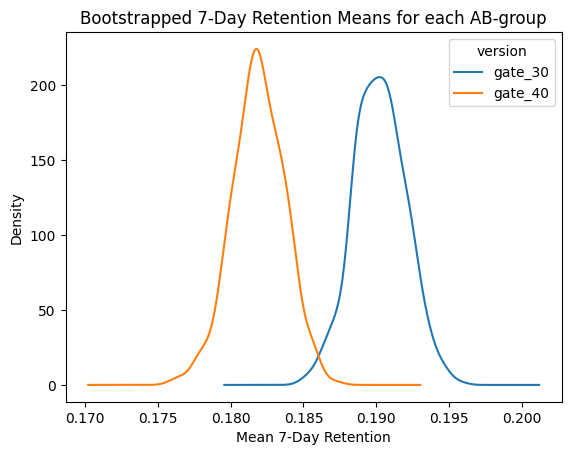

In [57]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_7d.plot.kde()
ax.set_title('Bootstrapped 7-Day Retention Means for each AB-group')
ax.set_xlabel('Mean 7-Day Retention');

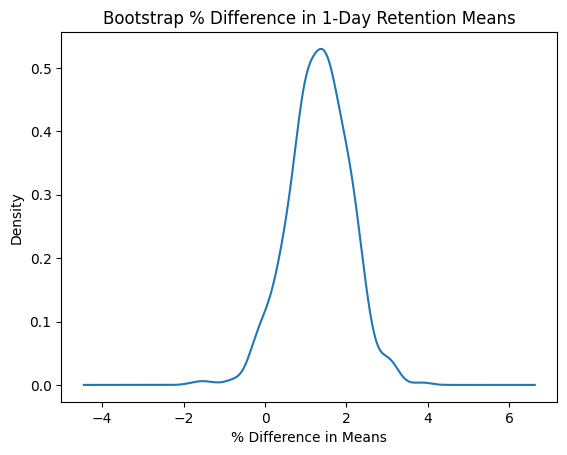

In [58]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = ((boot_1d.gate_30 - boot_1d.gate_40)
                   / boot_1d.gate_40 * 100)

# Plotting the bootstrap % difference
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('% Difference in Means')
ax.set_title('Bootstrap % Difference in 1-Day Retention Means');

'100.0%'

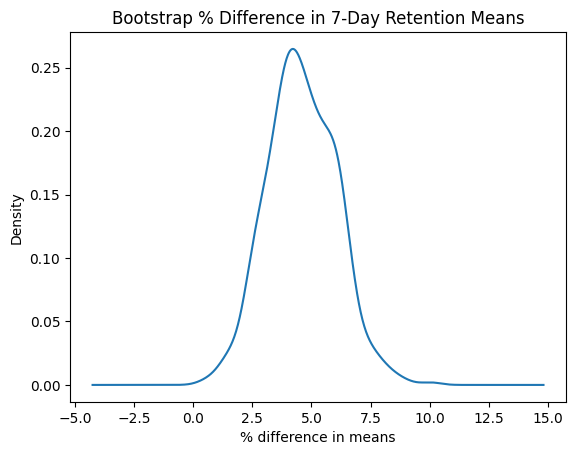

In [59]:
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / 
                   boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")
ax.set_title('Bootstrap % Difference in 7-Day Retention Means');

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).mean()

# Pretty printing the probability
'{0:.1%}'.format(prob)

<p>From these chart, we can see that the most likely % difference is around 1% - 2% for 1-day retention. For 7-days retention the most likely % difference is around 2% - 5%. Moreover, the most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? Let's calculate that as well.</p>

In [60]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0.0).sum() / len(boot_1d['diff'])

# Pretty printing the probability
print('The probability that 1-day retention is greater when the gate is at level 30 is:', prob*100, '%')


The probability that 1-day retention is greater when the gate is at level 30 is: 95.39999999999999 %


In [61]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0.0).sum() / len(boot_7d['diff'])

# Pretty printing the probability
print('The probability that 7-day retention is greater when the gate is at level 30 is:', prob*100, '%')


The probability that 7-day retention is greater when the gate is at level 30 is: 100.0 %


## <font color="00bfff">5. The conclusion</font>

The bootstrap result tells us that there is strong evidence **99.8% probability** that 7-day retention is higher when the gate is at level 30 than when it is at level 40.

The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics.